# Notebook: Sistem Pendukung Investigasi Serangan Siber Berdasarkan Log Server Web dan Bisecting K-Means

Notebook ini membangun sistem analisis log server web untuk investigasi serangan siber, dengan pipeline:
1. Import library & setup lingkungan
2. Membaca & membersihkan data log
3. Ekstraksi & tokenisasi URL
4. Pembuatan embedding URL dengan BERT
5. Clustering URL menggunakan Bisecting K-Means
6. Visualisasi & analisis hasil cluster

## 1. Import Library dan Setup Lingkungan

Impor semua library yang diperlukan (pandas, numpy, torch, transformers, sklearn, dsb). Lakukan setup device (CPU/GPU) dan inisialisasi model/tokenizer BERT.

In [ ]:
import os
import re
import joblib
import torch
import numpy as np
from urllib.parse import urlparse, unquote
from transformers import BertTokenizer, BertModel
from custom_bkm import VerboseBisectingKMeans
from sklearn.preprocessing import normalize, OneHotEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from decoder import parse_dec_file_to_dataframe
from pprint import pprint
from tqdm import trange
from sklearn.feature_extraction.text import (
    HashingVectorizer,
    TfidfVectorizer,
    TfidfTransformer,
)
from scipy.sparse import csr_matrix, hstack, vstack, issparse, diags

In [3]:
# Select GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and model ONCE globally for efficiency
TOKENIZER = BertTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
MODEL = BertModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device)
MODEL.eval()

# Important Variables
input_log_file = "../inputs/sample.log"
output_dir = "../outputs/sample.csv"
num_clusters = 8

Using device: cpu


## 2. Membaca dan Membersihkan Data Log

Baca file log hasil decoding (menggunakan fungsi dari `decoder.py`), filter bot, dan parsing menjadi DataFrame yang siap diolah.

In [4]:
# Load and process log file
df = parse_dec_file_to_dataframe(input_log_file)
print(f"✅ Loaded {len(df)} rows from {input_log_file}")
df.head()

✅ Loaded 61 rows from ../inputs/sample.log


,ip,time,method,url,protocol,status,size,referrer,user_agent,extra,no
0,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,2
1,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,3
2,91.99.72.15,2019-01-22 00:26:17+00:00,GET,/product/31893/62100/سشوار-خانگی-پرنسلی-مدل-PR...,HTTP/1.1,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-,5
3,178.253.33.51,2019-01-22 00:26:19+00:00,GET,/m/product/32574/62991/ماشین-اصلاح-صورت-پرنسلی...,HTTP/1.1,200,20406,"https://www.zanbil.ir/m/filter/p5767,t156?name...",Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...,-,13
4,91.99.72.15,2019-01-22 00:26:19+00:00,GET,/product/10075/13903/مایکروفر-رومیزی-سامسونگ-م...,HTTP/1.1,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,-,15


In [5]:
print("=== DataFrame Info ===")
df.info()
print("\n=== DataFrame Describe ===")
print(df.describe(include='all'))
print("\n=== DataFrame Columns ===")
print(df.columns)

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   ip          61 non-null     object             
 1   time        61 non-null     datetime64[ns, UTC]
 2   method      61 non-null     object             
 3   url         61 non-null     object             
 4   protocol    61 non-null     object             
 5   status      61 non-null     int64              
 6   size        61 non-null     int64              
 7   referrer    61 non-null     object             
 8   user_agent  61 non-null     object             
 9   extra       61 non-null     object             
 10  no          61 non-null     int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 5.4+ KB

=== DataFrame Describe ===
                  ip                                 time method  \
count          

## 3. Ekstraksi dan Tokenisasi Fitur

Ekstrak fitur dari log, lakukan masking angka pada fitur URL, kategorisasi fitur status, dan tokenisasi path serta query string menjadi token-token teks.

In [6]:
def mask_numbers(url):
    """
    Replace numeric sequences in a URL with a placeholder token <NUM>.

    Args:
        url (str): A URL string that may contain numeric sequences.

    Returns:
        str: The URL string where all numeric sequences are replaced with <NUM>.
    """
    return re.sub(r'\d+', '<NUM>', url)



def split_url_tokens(url):
    """
    Tokenize a URL by splitting its path and query string.

    Args:
        url (str): A URL string to tokenize.

    Returns:
        list: List of token strings extracted from the URL.
    """
    parsed = urlparse(url)
    path = unquote(parsed.path)
    query = unquote(parsed.query)
    delimiters = r"[\/\-\_\=\&\?\.\+\(\)\[\]\<\>\{\}]"
    tokens = re.split(delimiters, path.strip("/")) + re.split(delimiters, query)
    return [tok for tok in tokens if tok]


def tokenize_user_agent(ua):
    """
    Tokenize a User-Agent string by splitting on common delimiters.

    Args:
        ua (str): User-Agent string.

    Returns:
        list: List of tokens such as browser, OS, and engine identifiers.
    """
    tokens = re.split(r"[ /;()]+", ua)
    return [tok for tok in tokens if tok]


def categorize_status(code):
    """
    Categorize HTTP status codes into standard ranges.

    Args:
        code (int): HTTP status code.

    Returns:
        str: Category label ("2xx", "3xx", "4xx", "5xx", or "other").
    """
    if 200 <= code < 300:
        return "2xx"
    elif 300 <= code < 400:
        return "3xx"
    elif 400 <= code < 500:
        return "4xx"
    elif 500 <= code < 600:
        return "5xx"
    else:
        return "other"

In [7]:
# --- Tokenisasi ---

# tokenized_urls = [" ".join(split_url_tokens(url)) for url in unique_urls]
tokenized_urls = [" ".join(split_url_tokens(mask_numbers(url))) for url in df['url']]
print("\n✅ tokenized_urls (head & tail)")
pprint(tokenized_urls[:5] + ["..."] + tokenized_urls[-5:])

# Method
methods = df['method'].tolist()
print("\n✅ methods (head)") 
pprint(methods[:5])

# Status kategori
status_categories = df['status'].apply(categorize_status).tolist()
print("\n✅ status_categories (head)")
pprint(status_categories[:5])

# Size mentah (akan dinormalisasi nanti)
sizes = df['size'].tolist()
print("\n✅ sizes (head)")
pprint(sizes[:5])

# User-Agent token
ua_tokens = [" ".join(tokenize_user_agent(ua)) for ua in df['user_agent']]
print("\n✅ user_agent tokens (head)")
pprint(ua_tokens[:3])


✅ tokenized_urls (head & tail)
['image NUM productModel NUM x NUM',
 'image NUM productModel NUM x NUM',
 'product NUM NUM سشوار خانگی پرنسلی مدل PR NUM AT',
 'm product NUM NUM ماشین اصلاح صورت پرنسلی مدل PR NUM AT',
 'product NUM NUM مایکروفر رومیزی سامسونگ مدل CE NUM',
 '...',
 'm updateVariation amp source origin https: www zanbil ir',
 'product NUM model NUM',
 'm updateVariation amp source origin https: www zanbil ir',
 'product NUM NUM عطر و ادکلن زنانه دیور مدل Poison Girl',
 'image NUM productModel NUM x NUM']

✅ methods (head)
['GET', 'GET', 'GET', 'GET', 'GET']

✅ status_categories (head)
['2xx', '2xx', '2xx', '2xx', '2xx']

✅ sizes (head)
[5667, 5379, 41483, 20406, 41725]

✅ user_agent tokens (head)
['Mozilla 5.0 Linux Android 6.0 ALE-L21 Build HuaweiALE-L21 AppleWebKit 537.36 '
 'KHTML, like Gecko Chrome 66.0.3359.158 Mobile Safari 537.36',
 'Mozilla 5.0 Linux Android 6.0 ALE-L21 Build HuaweiALE-L21 AppleWebKit 537.36 '
 'KHTML, like Gecko Chrome 66.0.3359.158 Mobile Safa

## 4. Vektorisasi Fitur

Konversi token-token URL menjadi embedding vektor menggunakan berbagai metode, encoding metode dan status, normalisasi size, dan vektorisasi tfidf untuk user-agent.

In [8]:
# UTILS

def get_cache_dir(subfolder=None):
    """
    Pastikan folder cache exist. Jika subfolder diberikan (misal 'embeddings'),
    maka buat juga subfolder tersebut dan return path-nya.

    Returns:
        str: Path folder cache atau subfolder dalam cache.
    """
    # project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))  # dari app ke root
    project_root = ".."
    cache_root = os.path.join(project_root, "cache")
    os.makedirs(cache_root, exist_ok=True)

    if subfolder:
        path = os.path.join(cache_root, subfolder)
        os.makedirs(path, exist_ok=True)
        return path

    return cache_root


In [9]:
def generate_url_hashing(url_list, n_features=1024, batch_size=50000):
    """
    Generate feature vectors for URLs using a hashing trick.

    Args:
        url_list (list): List of tokenized URL strings.
        n_features (int, optional): Number of output features. Defaults to 1024.
        batch_size (int, optional): Number of URLs per batch. Defaults to 50000.

    Returns:
        scipy.sparse.csr_matrix: L2-normalized sparse matrix of hashed URL features.
    """
    vectorizer = HashingVectorizer(
        n_features=n_features,
        alternate_sign=False,
        dtype=np.float32
    )

    X_batches = []
    for i in range(0, len(url_list), batch_size):
        batch = url_list[i:i + batch_size]
        X_batches.append(vectorizer.transform(batch))
    X = vstack(X_batches)
    return normalize(X, norm='l2', copy=False)


def generate_url_tfidf(url_list, n_features=1024, batch_size=50000):
    """
    Generate scalable TF-IDF vectors for URLs using a hashing + IDF approach.

    Args:
        url_list (list): List of tokenized URL strings.
        n_features (int, optional): Number of output features. Defaults to 1024.
        batch_size (int, optional): Number of URLs per batch. Defaults to 50000.

    Returns:
        scipy.sparse.csr_matrix: Sparse TF-IDF feature matrix for URLs.
    """
    hv = HashingVectorizer(n_features=n_features, alternate_sign=False, dtype=np.float32)

    tf_batches = []
    for i in range(0, len(url_list), batch_size):
        batch = url_list[i:i + batch_size]
        tf_batches.append(hv.transform(batch))
    X_tf = vstack(tf_batches)

    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_tf)
    return normalize(X_tfidf, norm='l2', copy=False)


def generate_url_bert(url_list, TOKENIZER, MODEL, device, batch_size=32, out_path="embeddings"):
    """
    Generate BERT embeddings for a list of preprocessed URL strings.

    Args:
        url_list (list): List of preprocessed URL strings.
        TOKENIZER (transformers tokenizer): Pre-trained tokenizer.
        MODEL (transformers model): Pre-trained model (e.g. BERT, MiniLM, etc.).
        device (torch.device): Computation device ("cuda" or "cpu").
        batch_size (int, optional): Batch size for embedding. Defaults to 32.
        out_path (str, optional): Path for memmap file to store embeddings.

    Returns:
        np.ndarray or np.memmap: Dense array or memory-mapped embeddings.
    """
    MODEL.eval()
    dim = MODEL.config.hidden_size

    if out_path:
        cache_embed_dir = get_cache_dir(out_path)
        bert_memmap_path = os.path.join(cache_embed_dir, "url_embeddings.memmap")
        fp = np.memmap(bert_memmap_path, dtype=np.float32, mode='w+', shape=(len(url_list), dim))
        use_memmap = True
    else:
        fp = []  # list biasa
        use_memmap = False

    for i in trange(0, len(url_list), batch_size, desc="Embedding URLs"):
        batch = url_list[i : i + batch_size]
        inputs = TOKENIZER(batch, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)

        with torch.no_grad():
            if device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    outputs = MODEL(**inputs)
            else:
                outputs = MODEL(**inputs)

        emb = outputs.last_hidden_state.mean(dim=1).cpu().float().numpy()

        if use_memmap:
            fp[i : i + len(batch)] = emb
        else:
            fp.append(emb)

        del emb, inputs, outputs
        try:
            torch.cuda.empty_cache()
        except:
            pass

    if use_memmap:
        del fp 
        return np.memmap(bert_memmap_path, dtype=np.float32, mode='r', shape=(len(url_list), dim))
    else:
        return np.vstack(fp)

In [10]:
def encode_methods(methods):
    """
    One-hot encode HTTP methods (e.g., GET, POST, PUT) as sparse vectors.

    Args:
        methods (list[str]): List of HTTP method strings.

    Returns:
        scipy.sparse.csr_matrix: One-hot encoded sparse matrix for methods.
    """
    enc = OneHotEncoder(sparse_output=True, dtype=np.float32)
    return enc.fit_transform(np.array(methods).reshape(-1, 1))


def encode_statuses(status_categories):
    """
    One-hot encode HTTP status code categories (e.g., 2xx, 3xx, 4xx, 5xx).

    Args:
        status_categories (list[str]): List of status category labels.

    Returns:
        scipy.sparse.csr_matrix: One-hot encoded sparse matrix for statuses.
    """
    enc = OneHotEncoder(sparse_output=True, dtype=np.float32)
    return enc.fit_transform(np.array(status_categories).reshape(-1, 1))


def normalize_sizes(sizes):
    """
    Normalize response sizes to the [0, 1] range and return as sparse matrix.

    Args:
        sizes (list[int]): List of response sizes.

    Returns:
        scipy.sparse.csr_matrix: Normalized response sizes.
    """
    scaler = MinMaxScaler()
    arr = scaler.fit_transform(np.array(sizes, dtype=np.float32).reshape(-1, 1))
    return csr_matrix(arr)


def vectorize_user_agents(ua_tokens, max_features=200, out_path=None):
    """
    Convert tokenized User-Agent strings into TF-IDF sparse vectors.

    Args:
        ua_tokens (list[str]): List of tokenized User-Agent strings.
        max_features (int, optional): Maximum vocabulary size. Defaults to 200.
        out_path (str, optional): Subdirectory name under cache/ to store or load TF-IDF vocabulary.
    
    Returns:
        scipy.sparse.csr_matrix: TF-IDF feature matrix for User-Agent tokens.
    """
    if not out_path:
        vectorizer = TfidfVectorizer(max_features=max_features, dtype=np.float32)
        return vectorizer.fit_transform(ua_tokens)

    cache_feat_dir = get_cache_dir(out_path)
    vocab_path = os.path.join(cache_feat_dir, "ua_tfidf_vocab.pkl")

    if os.path.exists(vocab_path):
        data = joblib.load(vocab_path)
        vectorizer = TfidfVectorizer(dtype=np.float32, vocabulary=data["vocab"])
        vectorizer.idf_ = data["idf"]          # <- penting!
        vectorizer._tfidf._idf_diag = diags(data["idf"])
        return vectorizer.transform(ua_tokens)

    vectorizer = TfidfVectorizer(max_features=max_features, dtype=np.float32)
    X = vectorizer.fit_transform(ua_tokens)

    joblib.dump({"vocab": vectorizer.vocabulary_, "idf": vectorizer.idf_}, vocab_path)

    return X

In [11]:
def combine_features(*arrays):
    """
    Safely combine multiple feature matrices (sparse or dense) into one matrix.

    Automatically converts all dense matrices to sparse if any input is sparse,
    ensuring compatibility and efficient memory usage for large datasets.

    Args:
        *arrays: Variable-length list of matrices (np.ndarray or csr_matrix).

    Returns:
        scipy.sparse.csr_matrix or np.ndarray: Combined feature matrix.
    """
    arrays = [a for a in arrays if a is not None]
    if any(issparse(a) for a in arrays):
        arrays = [csr_matrix(a) if not issparse(a) else a for a in arrays]
        return hstack(arrays)
    return np.hstack(arrays)

In [12]:
# URL embeddings (pilih salah satu)
# url_embeddings = generate_url_hashing(tokenized_urls)
# url_embeddings = generate_url_tfidf(tokenized_urls)
url_embeddings = generate_url_bert(tokenized_urls, TOKENIZER, MODEL, device, out_path="embeddings")

if not issparse(url_embeddings):
    url_embeddings = normalize(url_embeddings, norm='l2', copy=False)

# Fitur tambahan
method_enc = encode_methods(df["method"])
status_enc = encode_statuses(df["status"].apply(categorize_status))
size_enc = normalize_sizes(df["size"])
ua_tokens = [" ".join(tokenize_user_agent(ua)) for ua in df["user_agent"]]
ua_enc = vectorize_user_agents(ua_tokens, out_path="ua_features")

# Gabungkan semua fitur jadi satu matriks
final_features = combine_features(url_embeddings, method_enc, status_enc, size_enc, ua_enc)
print(f"✅ final_features shape: {final_features.shape}")

Embedding URLs: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

✅ final_features shape: (61, 466)


In [13]:
import time
import gc
import numpy as np

def compare_embedding_methods(tokenized_urls, TOKENIZER, MODEL, device,
                              n_samples=None,
                              hashing_features=1024,
                              tfidf_features=1024,
                              bert_batch=32,
                              keep_embeddings=False):
    """
    Bandingkan waktu eksekusi untuk generate_url_hashing, generate_url_tfidf, generate_url_bert.
    Args:
        tokenized_urls: list[str]
        TOKENIZER, MODEL, device: untuk BERT
        n_samples: ambil subset acak untuk benchmarking (None = semua)
        hashing_features, tfidf_features, bert_batch: parameter masing-masing method
        keep_embeddings: jika True, return embeddings bersama timings (ingat memory)
    Returns:
        dict: { 'hashing': {time, shape, emb?}, 'tfidf': {...}, 'bert': {...} }
    """
    urls = tokenized_urls
    if n_samples is not None and n_samples < len(tokenized_urls):
        rng = np.random.default_rng(42)
        idx = rng.choice(len(tokenized_urls), n_samples, replace=False)
        urls = [tokenized_urls[i] for i in idx]

    results = {}
    # --- Hashing ---
    gc.collect()
    t0 = time.perf_counter()
    emb_hash = generate_url_hashing(urls, n_features=hashing_features)
    dt = time.perf_counter() - t0
    results['hashing'] = {'time_s': dt, 'shape': getattr(emb_hash, 'shape', None)}
    if keep_embeddings:
        results['hashing']['emb'] = emb_hash
    else:
        del emb_hash
    gc.collect()

    # --- TF-IDF (hashing + idf) ---
    gc.collect()
    t0 = time.perf_counter()
    emb_tfidf = generate_url_tfidf(urls, n_features=tfidf_features)
    dt = time.perf_counter() - t0
    results['tfidf'] = {'time_s': dt, 'shape': getattr(emb_tfidf, 'shape', None)}
    if keep_embeddings:
        results['tfidf']['emb'] = emb_tfidf
    else:
        del emb_tfidf
    gc.collect()

    # --- BERT ---
    gc.collect()
    t0 = time.perf_counter()
    emb_bert = generate_url_bert(urls, TOKENIZER, MODEL, device, batch_size=bert_batch)
    dt = time.perf_counter() - t0
    results['bert'] = {'time_s': dt, 'shape': getattr(emb_bert, 'shape', None)}
    if keep_embeddings:
        results['bert']['emb'] = emb_bert
    else:
        del emb_bert
    gc.collect()

    return results

# Example usage (let notebook run this cell):
timings = compare_embedding_methods(tokenized_urls, TOKENIZER, MODEL, device, n_samples=5000)
print(timings)

Embedding URLs: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


{'hashing': {'time_s': 0.0009654000004957197, 'shape': (61, 1024)}, 'tfidf': {'time_s': 0.0013187000004108995, 'shape': (61, 1024)}, 'bert': {'time_s': 0.18478110000069137, 'shape': (61, 384)}}


## 5. Clustering Log Menggunakan Bisecting K-Means (Library dan Manual)

Implementasikan dan jalankan algoritma Bisecting K-Means hasil final fitur, lalu kelompokkan berdasarkan hasil cluster.

In [14]:
def evaluate_clusters(features, labels):
    """
    Evaluate clustering results using standard metrics (safe for large/sparse data).

    Args:
        features (np.ndarray or scipy.sparse matrix): Feature matrix.
        labels (np.ndarray): Cluster labels.

    Returns:
        dict: Dictionary with metric results.
    """
    n_labels = len(set(labels))
    if n_labels < 2:
        return {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None
        }

    results = {}

    # 1️⃣ Silhouette score (supports sparse input)
    try:
        results["silhouette"] = silhouette_score(features, labels, sample_size=20000 if len(labels) > 20000 else None)
    except Exception as e:
        results["silhouette"] = None
        print(f"⚠️ Silhouette score skipped: {e}")

    # 2️⃣ Davies–Bouldin and Calinski–Harabasz require dense data
    if issparse(features):
        # Avoid full toarray() for large datasets (could eat 10+ GB)
        if features.shape[0] * features.shape[1] < 50_000 * 1500:
            print("ℹ️ Converting sparse matrix to dense for small sample...")
            X_dense = features.toarray()
        else:
            print("⚠️ Skipping Davies-Bouldin & Calinski-Harabasz (too large or sparse).")
            results["davies_bouldin"] = None
            results["calinski_harabasz"] = None
            return results
    else:
        X_dense = features

    # 3️⃣ Compute remaining metrics safely
    try:
        results["davies_bouldin"] = davies_bouldin_score(X_dense, labels)
    except Exception as e:
        results["davies_bouldin"] = None
        print(f"⚠️ Davies-Bouldin skipped: {e}")

    try:
        results["calinski_harabasz"] = calinski_harabasz_score(X_dense, labels)
    except Exception as e:
        results["calinski_harabasz"] = None
        print(f"⚠️ Calinski-Harabasz skipped: {e}")

    return results


def visualize_clusters(features, labels, out_file="clusters.png", save_plot=True, title=None):
    """
    Visualize clusters using PCA 2D projection.

    Args:
        features (np.ndarray): Feature matrix.
        labels (np.ndarray): Cluster labels.
        out_file (str): Path to save PNG plot.
        save_plot (bool): If True, save plot to file.
        title (str): Optional title for the plot.
    """
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter, label="Cluster ID")
    if title:
        plt.title(title)
    else:
        plt.title("Cluster Visualization (PCA)")
    if save_plot:
        plt.savefig(out_file)
        print(f"✅ Cluster visualization saved to {out_file}")
    plt.show()


🚀 Starting clustering process...


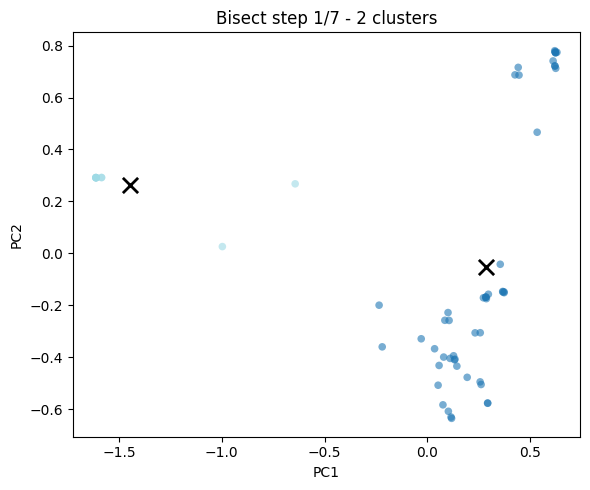

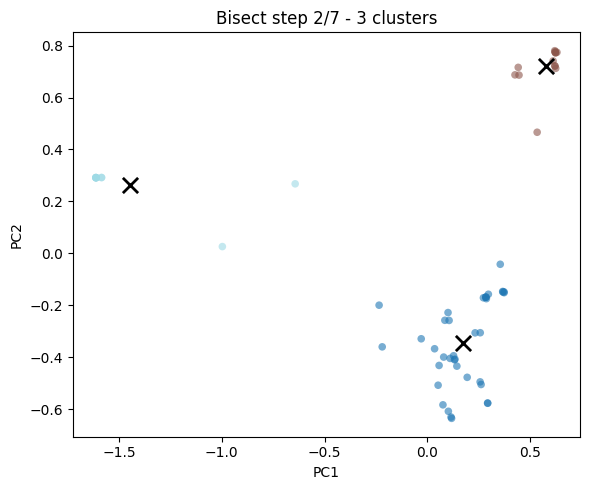

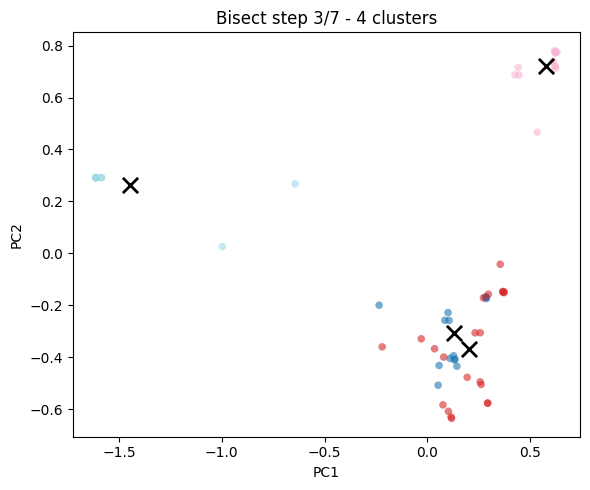

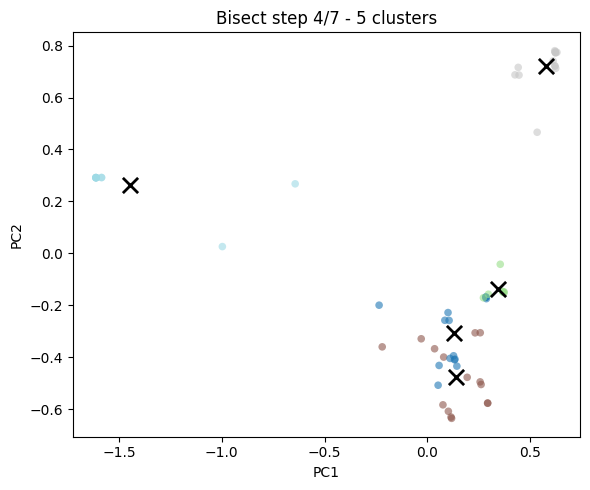

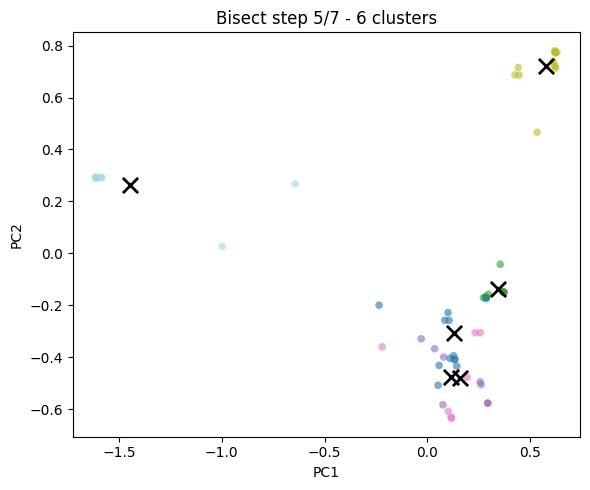

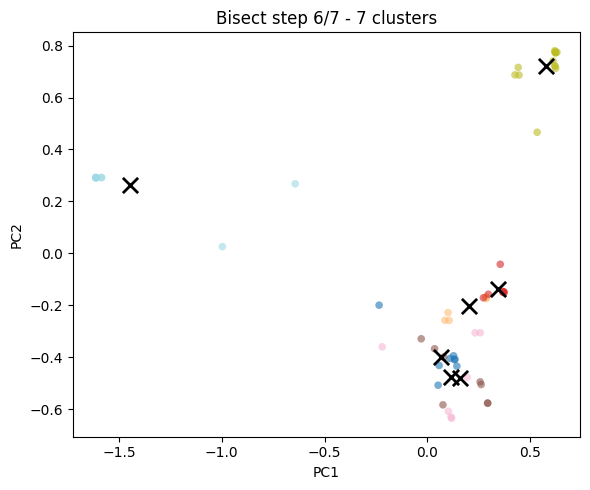

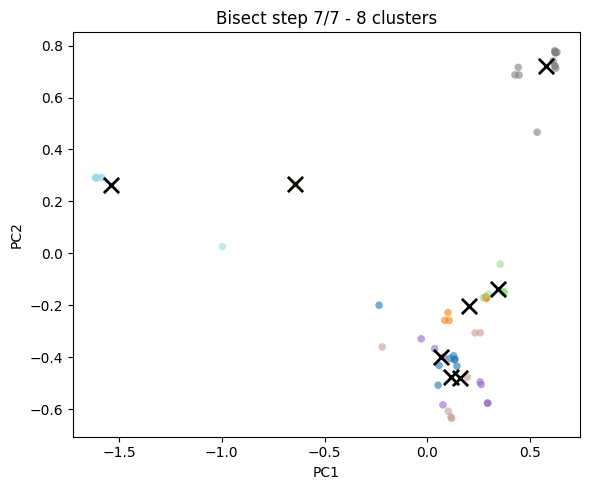

✅ Clustering completed. Total clusters: 8
💾 Writing compressed CSV to: ../outputs/sample.csv.gz
✅ Compressed CSV saved: ../outputs/sample.csv.gz
🧩 Writing text summary... -> ../outputs/sample.txt
✅ Cluster summaries saved: ../outputs/sample.txt
ℹ️ Converting sparse matrix to dense for small sample...
📈 Cluster Evaluation: {'silhouette': 0.45168983936309814, 'davies_bouldin': 1.0536259214002643, 'calinski_harabasz': 18.580196380615234}


In [15]:
def cluster_logs(df, features, out_path, n_clusters):
    """
    Cluster web server logs using feature embeddings and Bisecting KMeans,
    optimized for large-scale datasets with gzip-compressed output.

    Args:
        df (pd.DataFrame): DataFrame of log entries.
        features (np.ndarray or scipy.sparse matrix): Feature matrix for clustering.
        out_path (str): Output path ending with ".csv" (example: "outputs/result.csv").
        n_clusters (int): Number of clusters.

    Returns:
        None
    """

    # === 1. Clustering process ===
    print("🚀 Starting clustering process...")
    bkm = VerboseBisectingKMeans(
        n_clusters=n_clusters,
        random_state=42,
        init="k-means++",
        n_init=5,
    )
    bkm.fit_verbose(features, plot=True)
    labels = bkm.labels_
    print(f"✅ Clustering completed. Total clusters: {n_clusters}")

    # === 2. Attach cluster labels ===
    df_label = df.copy()
    df_label["cluster"] = labels

    # === 3. Define output paths ===
    base, _ = os.path.splitext(out_path)
    csv_path = f"{base}.csv.gz"
    txt_path = f"{base}.txt"

    # === 4. Save compressed CSV efficiently ===
    chunk_size = 100_000
    print(f"💾 Writing compressed CSV to: {csv_path}")
    with open(csv_path, "wb") as f:  # gzip stream write
        import gzip
        with gzip.open(f, "wt", encoding="utf-8", newline="") as gz:
            # Write header
            df_label.head(0).to_csv(gz, index=False)
            # Write in chunks
            for i in range(0, len(df_label), chunk_size):
                df_label.iloc[i:i+chunk_size].to_csv(gz, header=False, index=False)
    print(f"✅ Compressed CSV saved: {csv_path}")

    # === 5. Write summary TXT (truncated for huge data) ===
    max_per_cluster = 1000 if len(df_label) > 1_000_000 else None
    print(f"🧩 Writing text summary... -> {txt_path}")
    with open(txt_path, "w", encoding="utf-8") as f:
        for cluster_id in range(n_clusters):
            cluster_data = df_label[df_label["cluster"] == cluster_id]
            f.write(f"\nCluster {cluster_id} ({len(cluster_data)} entries):\n")
            if max_per_cluster:
                cluster_data = cluster_data.head(max_per_cluster)
                f.write(f"  [Showing first {max_per_cluster} entries]\n")
            for _, row in cluster_data.iterrows():
                f.write(f"  {row['method']} {row['url']} [{row['status']}]\n")
    print(f"✅ Cluster summaries saved: {txt_path}")

    # === 6. Evaluate clustering (sample-based for large data) ===
    if len(df_label) > 200_000:
        print("⚠️ Large dataset detected, evaluating on sample of 200k entries...")
        idx = np.random.choice(len(df_label), 200_000, replace=False)
        sample_features = features[idx] if not issparse(features) else features[idx, :]
        sample_labels = labels[idx]
        metrics = evaluate_clusters(sample_features, sample_labels)
    else:
        metrics = evaluate_clusters(features, labels)

    print("📈 Cluster Evaluation:", metrics)
    
cluster_logs(df, final_features, output_dir, num_clusters)